In [1]:
## System
import sys
import os
from collections import defaultdict
from collections import OrderedDict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Fig utils
from fig_utils import (get_pr_vars, 
                       plot_combined_pr_curve)

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## Read in HGMD pathogenic set
patho_vars =  pd.read_csv("../data/hgmd.pathogenic.base.400bp_ConSplice.txt", sep = "\t", index_col = False)
patho_vars = patho_vars.rename(columns = {"#chrom":"chrom"})

In [3]:
## Get relative positions
patho_vars["relative_pos"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location))), axis = 1)

patho_vars["relative_pos2"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location)) if abs(int(x.location)) < 11 else "Deep Intronic" if (x.type == "as" and int(x.location) < -10) or (x.type == "ds" and int(x.location) > 10) else "Deep Exonic" if (x.type == "ds" and int(x.location) < -10) or (x.type == "as" and int(x.location) > 10) else "MISSING"  ), axis = 1)

In [4]:
## Filter varaints

### Keep variants if they have CADD score, SpliceAI score, SQUIRLS score, and ConSplice score

patho_vars = patho_vars.loc[~(patho_vars["400bp_ConSplice_unweighted"].isna()) & ~(patho_vars.MAX_SpliceAI.isna()) & ~(patho_vars.CADD_PHRED.isna()) & ~(patho_vars.MAX_SQUIRLS.isna()) & ~(patho_vars.chrom.isna())  &(patho_vars.chrom != "X")]

In [5]:
## Load benign variants 
### Filter for validated alternative splicing benign variants in GTEx
benign_vars = pd.read_csv("../data/benign.combined.base.400bp_ConSplice.txt", sep = "\t", index_col = False)
benign_vars = benign_vars.rename(columns = {"#chrom":"chrom"})
benign_vars = benign_vars.loc[benign_vars.dataset == "GTEx"]

In [6]:
## Set labels
patho_vars["patho_label"] = 1
benign_vars["patho_label"] = 0

In [7]:
## Combine patho and benign sets
combined_df = pd.concat([patho_vars,benign_vars])

In [8]:
score_dict = OrderedDict({"400bp_ConSplice_unweighted":{"col": "400bp_ConSplice_unweighted","label":"400bp Unweighted", "color": sns.color_palette("colorblind")[0]},
                          "400bp_ConSplice_linear_weighted":{"col": "400bp_ConSplice_linear_weighted","label":"400bp Linear Weighted", "color": sns.color_palette("colorblind")[1]},
                          "400bp_ConSplice_PHRED_weighted":{"col": "400bp_ConSplice_PHRED_weighted","label":"400bp PHRED Weighted", "color": sns.color_palette("colorblind")[2]},
                          "400bp_ConSplice_one_minus_prop":{"col": "400bp_ConSplice_one_minus_prop","label":"400bp 1 - Prop. Weighted", "color": sns.color_palette("colorblind")[3]},
                          "400bp_ConSplice_one_over_prop":{"col": "400bp_ConSplice_one_over_prop","label":"400bp 1 / Prop. Weighted", "color": sns.color_palette("colorblind")[4]},
                          "400bp_ConSplice_one_over_mr":{"col": "400bp_ConSplice_one_over_mr","label":"400bp 1 / MR Weighted", "color": sns.color_palette("colorblind")[5]},
                          })

In [9]:
## Get the patho and benign set
patho_test_set = combined_df.loc[combined_df.patho_label == 1]
benign_test_set = combined_df.loc[combined_df.patho_label == 0]

In [10]:
scored_combined_df = pd.concat([patho_test_set,benign_test_set])

PR AUC=0.910, Avg. Precision Score=0.910
PR AUC=0.911, Avg. Precision Score=0.911
PR AUC=0.909, Avg. Precision Score=0.909
PR AUC=0.909, Avg. Precision Score=0.909
PR AUC=0.917, Avg. Precision Score=0.917
PR AUC=0.910, Avg. Precision Score=0.910


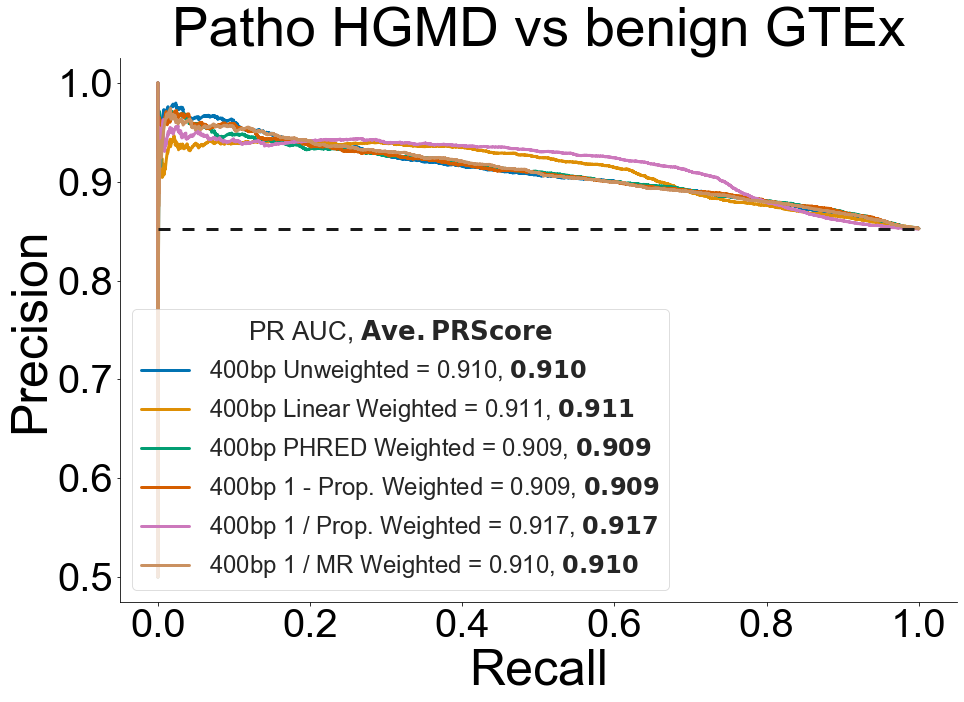

In [11]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(scored_combined_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label": info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (patho_test_set.shape[0] / (patho_test_set.shape[0] + benign_test_set.shape[0]))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Patho HGMD vs benign GTEx"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure16_F.svg')


In [12]:
print("Number of pathogenic variants = {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 1].shape[0]))
print("Number of benign variants =     {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 0].shape[0]))

Number of pathogenic variants = 18295
Number of benign variants =     3173


In [13]:
non_canonical_combined_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A-1") & (patho_test_set.relative_pos != "A-2") & (patho_test_set.relative_pos != "D+1") & (patho_test_set.relative_pos != "D+2")],benign_test_set.loc[(benign_test_set.relative_pos != "A-1") & (benign_test_set.relative_pos != "A-2") & (benign_test_set.relative_pos != "D+1") & (benign_test_set.relative_pos != "D+2")]])


PR AUC=0.768, Avg. Precision Score=0.769
PR AUC=0.778, Avg. Precision Score=0.778
PR AUC=0.769, Avg. Precision Score=0.769
PR AUC=0.767, Avg. Precision Score=0.768
PR AUC=0.786, Avg. Precision Score=0.786
PR AUC=0.771, Avg. Precision Score=0.771


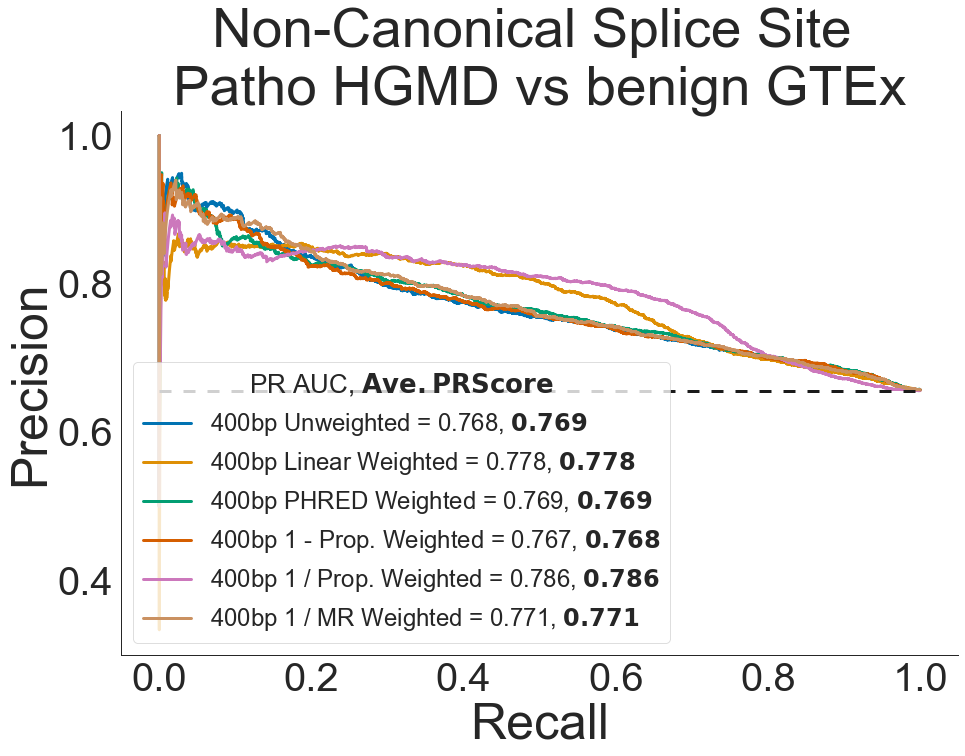

In [14]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_canonical_combined_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
               + 
               non_canonical_combined_df[non_canonical_combined_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Non-Canonical Splice Site \nPatho HGMD vs benign GTEx"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure17_F.svg')


In [15]:
print("Number of pathogenic variants = {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 1].shape[0]))
print("Number of benign variants =     {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 0].shape[0]))

Number of pathogenic variants = 5688
Number of benign variants =     2984


In [16]:
non_splice_region_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A+3") &
                                                     (patho_test_set.relative_pos != "A+2") & 
                                                     (patho_test_set.relative_pos != "A+1") & 
                                                     (patho_test_set.relative_pos != "A-1") & 
                                                     (patho_test_set.relative_pos != "A-2") & 
                                                     (patho_test_set.relative_pos != "A-3") &
                                                     (patho_test_set.relative_pos != "A-4") & 
                                                     (patho_test_set.relative_pos != "A-5") & 
                                                     (patho_test_set.relative_pos != "A-6") & 
                                                     (patho_test_set.relative_pos != "A-7") & 
                                                     (patho_test_set.relative_pos != "A-8") &
                                                     (patho_test_set.relative_pos != "D-3") & 
                                                     (patho_test_set.relative_pos != "D-2") & 
                                                     (patho_test_set.relative_pos != "D-1") & 
                                                     (patho_test_set.relative_pos != "D+1") & 
                                                     (patho_test_set.relative_pos != "D+2") & 
                                                     (patho_test_set.relative_pos != "D+3") & 
                                                     (patho_test_set.relative_pos != "D+4") & 
                                                     (patho_test_set.relative_pos != "D+5") & 
                                                     (patho_test_set.relative_pos != "D+6") & 
                                                     (patho_test_set.relative_pos != "D+7") & 
                                                     (patho_test_set.relative_pos != "D+8")],
                                 benign_test_set.loc[(benign_test_set.relative_pos != "A+3") &
                                                     (benign_test_set.relative_pos != "A+2") & 
                                                     (benign_test_set.relative_pos != "A+1") & 
                                                     (benign_test_set.relative_pos != "A-1") & 
                                                     (benign_test_set.relative_pos != "A-2") & 
                                                     (benign_test_set.relative_pos != "A-3") &
                                                     (benign_test_set.relative_pos != "A-4") & 
                                                     (benign_test_set.relative_pos != "A-5") & 
                                                     (benign_test_set.relative_pos != "A-6") & 
                                                     (benign_test_set.relative_pos != "A-7") & 
                                                     (benign_test_set.relative_pos != "A-8") &
                                                     (benign_test_set.relative_pos != "D-3") & 
                                                     (benign_test_set.relative_pos != "D-2") & 
                                                     (benign_test_set.relative_pos != "D-1") & 
                                                     (benign_test_set.relative_pos != "D+1") & 
                                                     (benign_test_set.relative_pos != "D+2") & 
                                                     (benign_test_set.relative_pos != "D+3") & 
                                                     (benign_test_set.relative_pos != "D+4") & 
                                                     (benign_test_set.relative_pos != "D+5") & 
                                                     (benign_test_set.relative_pos != "D+6") & 
                                                     (benign_test_set.relative_pos != "D+7") & 
                                                     (benign_test_set.relative_pos != "D+8")]])


PR AUC=0.513, Avg. Precision Score=0.514
PR AUC=0.534, Avg. Precision Score=0.535
PR AUC=0.513, Avg. Precision Score=0.514
PR AUC=0.507, Avg. Precision Score=0.508
PR AUC=0.558, Avg. Precision Score=0.559
PR AUC=0.521, Avg. Precision Score=0.522


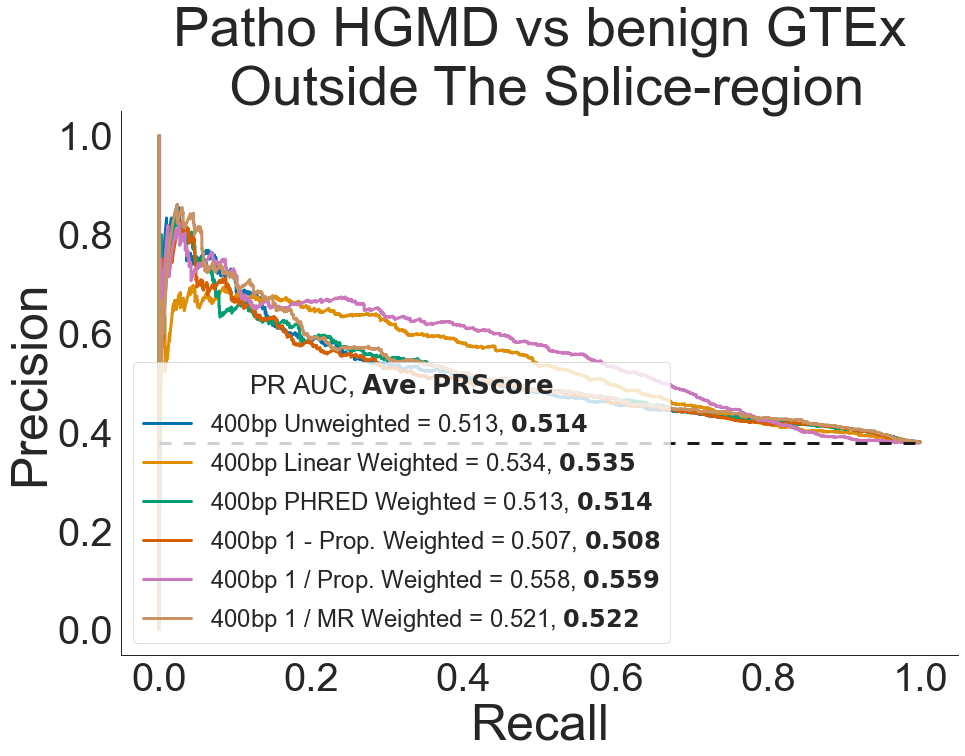

In [17]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_splice_region_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
              / 
              (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
               + 
               non_splice_region_df[non_splice_region_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Patho HGMD vs benign GTEx\n Outside The Splice-region"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure18_F.svg')
